In [71]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [72]:
root_dir = "/kaggle/input/titanic/{fname}"
train = pd.read_csv(root_dir.format(fname = "train.csv"))
test = pd.read_csv(root_dir.format(fname = "test.csv"))
gender_sub = pd.read_csv(root_dir.format(fname = "gender_submission.csv"))

In [3]:
train.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's drop some columns. Age would be an important predictor as it would make sense for younger people to be allowed on the lifeboatds first, vs older people (I HOPE!). And it's not something we can "interpolate" for. I'll also drop _Cabin_, for now.

In [80]:
gender_sub.head(12)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [15]:
train[train.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [5]:
train_with_no_cabin = train.drop(columns="Cabin",inplace=False)

In [6]:
train_with_no_cabin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [7]:
train_cleaned = train_with_no_cabin.dropna(inplace=False)

In [8]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB


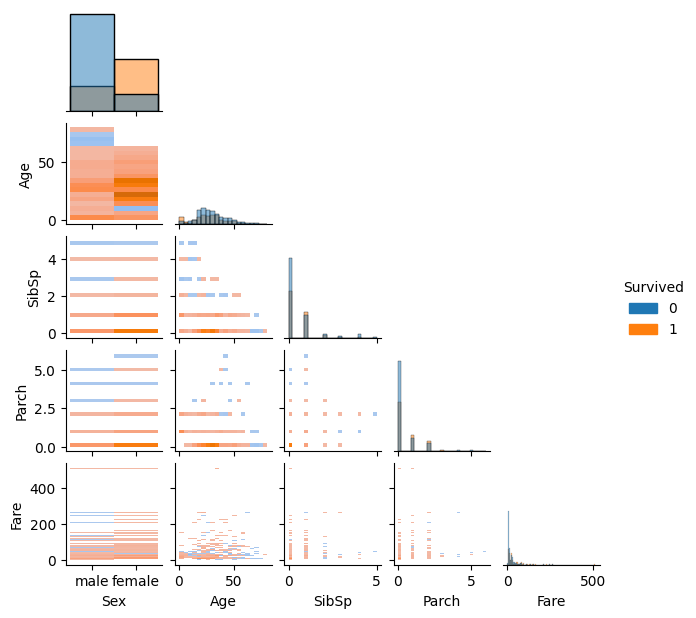

In [9]:
grid = sns.pairplot(data=train_cleaned, 
             x_vars=["Sex","Age","SibSp","Parch","Fare"],
             y_vars=["Sex","Age","SibSp","Parch","Fare"],
             hue="Survived",
             kind="hist",
            corner=True, dropna=True, height=1.25)

Now let's scale the numerical features _fare_ and _age_ as their values are changing over a fairly large range.

In [10]:
mean_age = train_cleaned.Age.mean()
std_age = train_cleaned.Age.std()
train_cleaned["Age_norm"] = (train_cleaned["Age"]-mean_age)/std_age
print(f"{mean_age = :0.3f}, {std_age = :0.3f}")

mean_age = 29.642, std_age = 14.493


In [11]:
mean_fare = train_cleaned.Fare.mean()
std_fare = train_cleaned.Fare.std()
train_cleaned["Fare_norm"] = (train_cleaned.Fare - mean_fare)/std_fare
print(f"{mean_fare = :0.3f}, {std_fare = :0.3f}")

mean_fare = 34.567, std_fare = 52.939


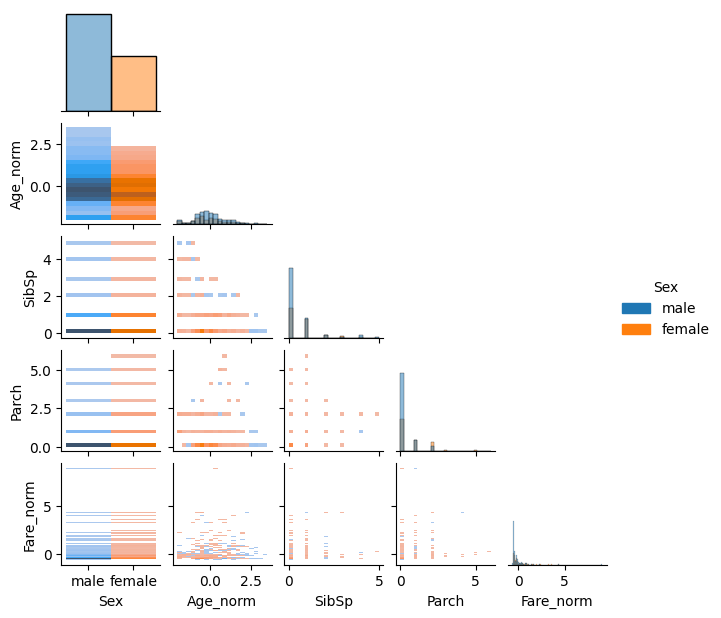

In [12]:
sns.pairplot(data=train_cleaned, x_vars=["Sex","Age_norm","SibSp","Parch","Fare_norm"],
             y_vars=["Sex","Age_norm","SibSp","Parch","Fare_norm"],
             hue="Sex",
             kind="hist",
            corner=True, dropna=True, height=1.25)

In [13]:
## what's up with the fare that's more than 5 std away?!
max_val = train_cleaned.Fare_norm.max() 
print(f"{max_val = :0.3f}, {train_cleaned.Fare_norm.max() * std_fare + mean_fare = :0.3f}")

max_val = 9.025, train_cleaned.Fare_norm.max() * std_fare + mean_fare = 512.329


I did a quick Google search and apparently the highest ticket price for the Titanic was around 2160USD at the time (1921), which in today's money is around a cr\*p load. So, for now I can keep that really large value. 
Now convert the features that are categorical to numeric features that we can use.

In [14]:
train_cleaned.replace(to_replace=["male","female"], value=[0, 1], inplace=True)
## embarked : C = Cherbourg, Q = Queenstown, S = Southampton
train_cleaned.replace(to_replace=["C", "Q", "S"], value=[0,1,2], inplace=True)
final_clean_train = train_cleaned.drop(labels=["Name", "Ticket", "Age", "Fare"], axis=1)


In [15]:
final_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    int64  
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Embarked     712 non-null    int64  
 7   Age_norm     712 non-null    float64
 8   Fare_norm    712 non-null    float64
dtypes: float64(2), int64(7)
memory usage: 55.6 KB


In [16]:
corr_mat_pearson = final_clean_train.corrwith(other=final_clean_train["Survived"], method="pearson")

In [17]:
print(abs(corr_mat_pearson).sort_values(ascending=False))

Survived       1.000000
Sex            0.536762
Pclass         0.356462
Fare_norm      0.266100
Embarked       0.181979
Parch          0.095265
Age_norm       0.082446
PassengerId    0.029526
SibSp          0.015523
dtype: float64


In [18]:
corr_mat_spearman = final_clean_train.corrwith(other=final_clean_train["Survived"], method="spearman")
print(abs(corr_mat_spearman).sort_values(ascending=False))

Survived       1.000000
Sex            0.536762
Pclass         0.357628
Fare_norm      0.335672
Embarked       0.169571
Parch          0.158864
SibSp          0.075780
Age_norm       0.057032
PassengerId    0.029948
dtype: float64


In [19]:
corr_mat_kendall = final_clean_train.corrwith(other=final_clean_train["Survived"], method="kendall")
print(abs(corr_mat_kendall).sort_values(ascending=False))

Survived       1.000000
Sex            0.536762
Pclass         0.339258
Fare_norm      0.276035
Embarked       0.166916
Parch          0.153273
SibSp          0.073220
Age_norm       0.047073
PassengerId    0.024470
dtype: float64


For between all three types of correlations, the numbers are consistent, mostly. Horrifyingly, age has a very small correlation coefficient.

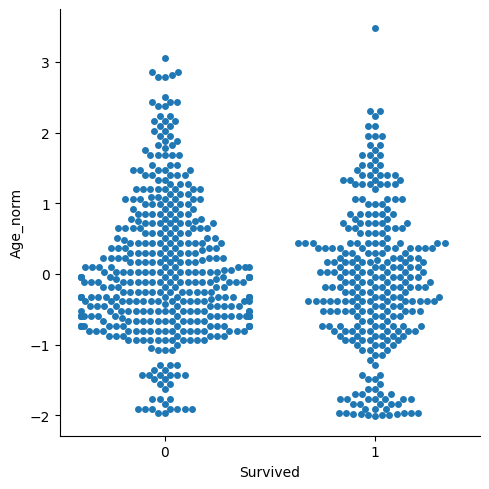

In [25]:
sns.catplot(data=final_clean_train, x="Survived", y="Age_norm", kind="swarm")

To my eyes, age does not seem to impart much information. The distribution of survivors seems to populations the younger ages a bit more but question is if this is strong enough to use age in the model. I do not think age would give enough information so I will drop it. 
So the list of the features I think would be sensible:
1. Sex 
2. Pclass   
3. Fare_norm
4. Embarked
5. Parch 

## Data Preprocessing and Model Building with SKlearn
After the adventures above, I can now create a pipeline for the preprocessing and the fitting steps of the model. What we need to do is
* separate _Survived_ as the target from the other features --> call `Y_train`
* convert _Sex_ to a binary flag: 0 if male, 1 if female
* one-hot-encode the cabin class _Pclass_: there's no reason to artifically create a larger value for a lower or higher class cabin
* scale the _Fare_ and _Age_ features. Before doing so, replace the null values in these variables by the median.
* one-hot_encode the _Embarked_ feature, the embarkation port.

In [73]:
train_Y = train["Survived"]
train_X = train.drop(columns=["Survived", "Ticket", "Name", "Cabin"], inplace=False)
test.drop(columns=["Ticket", "Name", "Cabin"], inplace=False)
for col in ["Embarked", "Sex", "Pclass"]:
    train_X[col] = train_X[col].astype("category")
    test[col] = test[col].astype("category")

In [74]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Pclass       891 non-null    category
 2   Sex          891 non-null    category
 3   Age          714 non-null    float64 
 4   SibSp        891 non-null    int64   
 5   Parch        891 non-null    int64   
 6   Fare         891 non-null    float64 
 7   Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(3)
memory usage: 37.9 KB


In [75]:
## create the pipeline:
numeric_features = ["Age", "Fare"]
categorical_features = ["Embarked", "Sex", "Pclass"]
numerical_processor = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                     ("scaler", StandardScaler())
                                     ]
                              )
categorical_processor = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(transformers=[
    ("numerical", numerical_processor, numeric_features),
    ("categorical", categorical_processor, categorical_features)])

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
model = Pipeline(steps=[("preprocessor", preprocess),
                       ("classifier", LogisticRegression())])
model.fit(train_X, train_Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex',
                                                   'Pclass'])])),
                ('classifier', LogisticRegression())])

In [79]:
predictions = model.predict(test)

In [82]:
with open("/kaggle/working/simple_prediction.csv", 'w') as f:
    f.write("PassengerId,Survived\n")
    for (pid, prediction) in zip(test.PassengerId, predictions):
        f.write(f"{pid},{prediction}\n")

    